## Imports

In [1]:
import pandas as pd
import numpy as np
import pypsa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import plotly
import datetime
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from utils import market_values, market_values_by_time_index, nodal_balance, carrier_colors

In [2]:
# dict(sorted(carrier_colors.items()))
# "aquamarine" in carrier_colors.values()

In [3]:
n =pypsa.Network("../data/raw/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


## Case Study

In [4]:
# example of bus and snapshot
bus = "DE0 1" # "AL0 0" # "DE0 1"
snap = "2013-01-01 09:00:00"
# energy carrier at bus
n.buses.carrier[bus]

'AC'

In [5]:
# active power at bus (positive if net generation at bus) in MW
n.buses_t.p.loc[snap,bus]

-1954.668418477922

In [6]:
# Lines (what reaches bus?)
# 1. sum of power @ lines with bus as bus0 and p0 (Active power at bus0 (positive if branch is withdrawing power from bus0)
n.lines_t.p0[n.lines[n.lines.bus0 == bus].index].sum(axis=1)
# 2. sum of power @ lines with bus as bus1 and p1 (Active power at bus1 (positive if branch is withdrawing power from bus1)
n.lines_t.p1[n.lines[n.lines.bus1 == bus].index].sum(axis=1)
# sum (if negative power is feed into bus)
lines = n.lines_t.p0[n.lines[n.lines.bus0 == bus].index].sum(axis=1) + n.lines_t.p1[n.lines[n.lines.bus1 == bus].index].sum(axis=1)
# sum should be the same value as the active power at the bus
lines[snap]

-1954.6684185022177

### Loads

In [7]:
# active power at bus (positive if net load) in MW
load = n.loads_t.p.loc[snap,bus]

### Generators

In [8]:
# generation of generators directly connected to bus
gens_index_direct = n.generators[n.generators.bus == bus].bus.index
# active power at bus (positive if net generation)
gen = n.generators_t.p.loc[snap, gens_index_direct].sum()

### Links

In [9]:
# links connected to the bus (bus0 of link)
links_index_direct = n.links[n.links.bus0 == bus].index
# Active power at bus1 (positive if branch is withdrawing power from bus0).
n.links_t.p0.loc[snap, links_index_direct]#.sum()

Link
DE0 1 H2 Electrolysis                   439.525110
DE0 1 battery charger                    80.833306
DE0 1 electricity distribution grid    3293.548085
Name: 2013-01-01 09:00:00, dtype: float64

In [10]:
# links connected to the bus (bus1 of link)
links_index_direct = n.links[n.links.bus1 == bus].index
# Active power at bus1 (positive if branch is withdrawing power from bus0).
n.links_t.p1.loc[snap, links_index_direct]#.sum()

Link
DE0 1 OCGT                                   -0.001216
DE0 1 H2 Fuel Cell                           -0.004148
DE0 1 battery discharger                     -0.117554
DE0 1 urban central gas CHP                  -0.002068
DE0 1 urban central gas CHP CC               -0.004359
DE0 1 urban central solid biomass CHP        -0.002846
DE0 1 urban central solid biomass CHP CC   -279.825313
Name: 2013-01-01 09:00:00, dtype: float64

In [11]:
# links connected to the bus (bus2 of link)
links_index_direct = n.links[n.links.bus2 == bus].index
# Active power at bus1 (positive if branch is withdrawing power from bus0).
n.links_t.p2.loc[snap, links_index_direct]

Link
DE0 1 services urban decentral DAC    0.001763
DE0 1 urban central DAC               0.001845
Name: 2013-01-01 09:00:00, dtype: float64

In [12]:
# links connected to the bus (bus3 of link)
links_index_direct = n.links[n.links.bus3 == bus].index
# Active power at bus1 (positive if branch is withdrawing power from bus0).
n.links_t.p3.loc[snap, links_index_direct]

Series([], Name: 2013-01-01 09:00:00, dtype: float64)

In [13]:
# links connected to the bus (bus4 of link)
links_index_direct = n.links[n.links.bus4 == bus].index
# Active power at bus1 (positive if branch is withdrawing power from bus0).
n.links_t.p4.loc[snap, links_index_direct]

Series([], Name: 2013-01-01 09:00:00, dtype: float64)

In [14]:
# Overall balance from links
links_balance = 0

for i in range(0,5):
    links_index_direct = n.links[n.links[f"bus{i}"] == bus].index
    # Active power at busi (positive if branch is withdrawing power from busi).
    links_balance += n.links_t[f"p{i}"].loc[snap, links_index_direct].sum()

links_balance

3533.952605577093

### Storage Units

In [15]:
# storage units
storage_index = n.storage_units[n.storage_units.bus == bus].index
# active power at bus (positive if net generation) in MW
su = n.storage_units_t.p.loc[snap, storage_index].sum()

### Stores

In [16]:
# stores
stores_index = n.stores[n.stores.bus == bus].index
# active power at bus (positive if net generation) in MW
st = n.stores_t.p.loc[snap, stores_index].sum()

### Overall aggregation

In [17]:
print(f"{gen} - {load} - {links_balance} + {su} + {st}")
gen - load - links_balance + su + st

1600.6981551887127 - 710.5694441264126 - 3533.952605577093 + -21.413968089540834 + 0.0


-2665.2378626043337

In [18]:
print(f"{gen} - {links_balance} + {su} + {st}")
gen  - links_balance + su + st

1600.6981551887127 - 3533.952605577093 + -21.413968089540834 + 0.0


-1954.668418477921

In [19]:
# active power at bus (positive if net generation at bus) in MW
n.buses_t.p.loc[snap, bus]

-1954.668418477922

Notes:
- shunt_impedances and transformers are not existent in network
- if you exclude the load in the balance, the bus is balanced. Why?

## Nodal Balance
- calculating import or export excess

### Electricity plot

In [38]:
carrier = ["AC", "low voltage"]
loads = ["electricity", "industry electricity", "agriculture electrcity"]
period = "2013-05"
nb_el = nodal_balance(n, carrier = carrier, time=period, aggregate=['component', 'bus'], energy=True)  # in units of energy
# convert from MW to GW and unstack
nb_el = nb_el.unstack(level=[1]) / 1000
load_el = nb_el[loads]
nb_el.drop
nb_el.head(3)

carrier,AC,BEV charger,DAC,DC,H2 Electrolysis,H2 Fuel Cell,PHS,V2G,agriculture electricity,battery charger,...,services rural resistive heater,services urban decentral air heat pump,services urban decentral resistive heater,solar,solar rooftop,urban central air heat pump,urban central gas CHP,urban central gas CHP CC,urban central resistive heater,urban central solid biomass CHP CC
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-05-01 00:00:00,1.728040e-14,-55.936232,-4.846786,1.364242e-15,-709.514501,NaN,4.023339,29.945463,-15.363392,-0.997366,...,-0.030702,-25.705127,-0.416672,NaN,NaN,-90.556552,NaN,NaN,-0.602949,2.601915
2013-05-01 03:00:00,7.275958e-15,-50.782888,-4.846752,-2.273737e-16,-671.842886,NaN,7.678835,21.005248,-15.363392,-0.124167,...,-0.579590,-33.211055,-1.930783,85.854984,9.973257,-115.387525,NaN,NaN,-2.954080,12.405591
2013-05-01 06:00:00,5.456968e-15,-352.207515,-4.846783,2.273737e-16,-1932.708992,NaN,-66.944392,7.030831,-15.363392,-231.662255,...,-1.004292,-29.251562,-1.344826,2479.263677,243.879720,-128.018142,NaN,NaN,-22.536103,0.005410


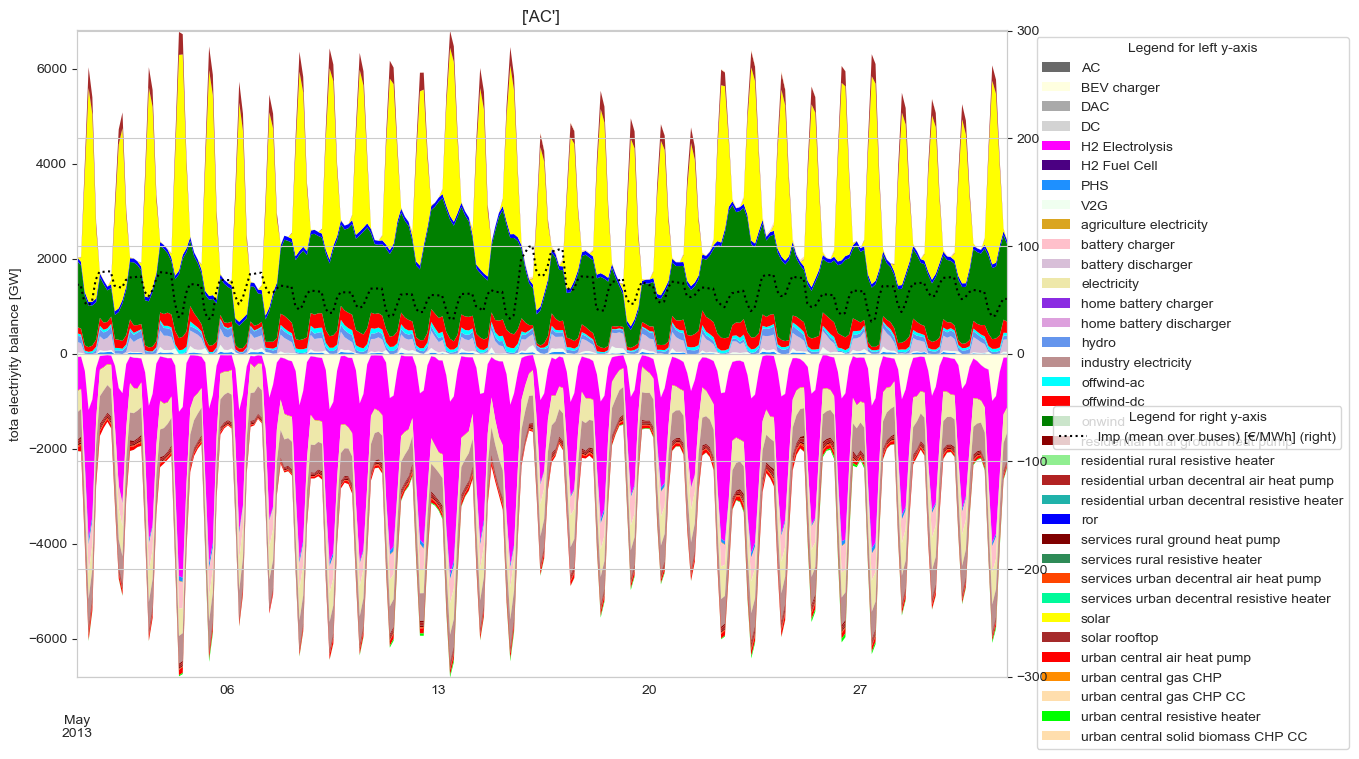

In [36]:
fig, ax = plt.subplots(figsize=(14, 8))

df = nb_el

# split into df with positive and negative values and get colors
df_neg, df_pos = df.clip(upper=0), df.clip(lower=0)
c_neg, c_pos = [carrier_colors[col] for col in df_neg.columns], [carrier_colors[col] for col in df_pos.columns]

# plot positive values
ax = df_pos.plot.area(ax=ax, stacked=True, color=c_pos, linewidth=0.)

# rename negative values so that they are not shown and plot negative values
ax = df_neg.rename(columns=lambda x: '_' + x).plot.area(ax=ax, stacked=True, color=c_neg, linewidth=0.)

# plot lmps
lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier.isin(carrier)].index].mean(axis=1)[period]
ax2 = lmps.plot(style=":", color="black", label="lmp (mean over buses) [€/MWh]", secondary_y=True)
# set limits of secondary y-axis
ax2.set_ylim([ - 3 * lmps.max() * abs(df_neg.sum(axis=1).min()) /  df_pos.sum(axis=1).max() , 3 * lmps.max()])

# plot loads
# n.load_t.p_set (gesetzte energie nachfrage)
# loads = n.loads_t.p[n.buses[n.buses.carrier.isin(carrier)].index].sum(axis=1)[period] / 1000
# loads.plot(style="--", color="black", label="loads (sum over buses) [GWh]", secondary_y=True)

# rescale the y-axis
ax.set_ylim([df_neg.sum(axis=1).min(), df_pos.sum(axis=1).max()])
ax.legend(ncol=1, loc="upper center", bbox_to_anchor=(1.2, 1), title="Legend for left y-axis")
ax2.legend(title="Legend for right y-axis",  loc="upper center", bbox_to_anchor=(1.205, 0.43))
ax.set_ylabel("tota electriyity balance [GW]")
ax.set_xlabel("")
ax.set_title(f"{carrier}")
fig.tight_layout()

# februrary; GAS CHP
# electricity, industry electricity aus negativem Teil rausnehmen und als load auf positive Teil plotten

In [37]:
nb_ac.

carrier,AC,BEV charger,DAC,DC,H2 Electrolysis,H2 Fuel Cell,PHS,V2G,agriculture electricity,battery charger,...,services rural resistive heater,services urban decentral air heat pump,services urban decentral resistive heater,solar,solar rooftop,urban central air heat pump,urban central gas CHP,urban central gas CHP CC,urban central resistive heater,urban central solid biomass CHP CC
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-05-01 00:00:00,1.728040e-14,-55.936232,-4.846786,1.364242e-15,-709.514501,NaN,4.023339,29.945463,-15.363392,-0.997366,...,-0.030702,-25.705127,-0.416672,NaN,NaN,-90.556552,NaN,NaN,-0.602949,2.601915
2013-05-01 03:00:00,7.275958e-15,-50.782888,-4.846752,-2.273737e-16,-671.842886,NaN,7.678835,21.005248,-15.363392,-0.124167,...,-0.579590,-33.211055,-1.930783,85.854984,9.973257,-115.387525,NaN,NaN,-2.954080,12.405591
2013-05-01 06:00:00,5.456968e-15,-352.207515,-4.846783,2.273737e-16,-1932.708992,NaN,-66.944392,7.030831,-15.363392,-231.662255,...,-1.004292,-29.251562,-1.344826,2479.263677,243.879720,-128.018142,NaN,NaN,-22.536103,0.005410
2013-05-01 09:00:00,-1.455192e-14,-1169.842882,-4.846792,0.000000e+00,-2727.122164,NaN,-113.215714,1.020200,-15.363392,-579.542177,...,-0.811179,-23.824914,-0.785737,4501.546951,435.987510,-122.440003,NaN,NaN,-19.747392,0.015149
2013-05-01 12:00:00,3.637979e-15,-951.646293,-4.846303,4.547474e-16,-2465.729728,NaN,-88.912298,1.024839,-15.363392,-486.231291,...,-0.777185,-21.992531,-0.726098,3939.859945,360.295190,-133.092573,NaN,NaN,-18.045108,0.005385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-05-31 09:00:00,-9.094947e-15,-980.009512,-4.823103,4.547474e-16,-2983.349810,NaN,-73.327041,0.776980,-15.363392,-535.224385,...,-0.549822,-14.468666,-0.530225,3863.784021,323.078729,-70.249304,NaN,NaN,-42.018232,0.435162
2013-05-31 12:00:00,1.364242e-14,-878.887014,-4.822735,-6.821210e-16,-2899.633047,NaN,-56.584516,0.808983,-15.363392,-451.781806,...,-0.543962,-13.703151,-0.508680,3550.877273,298.971796,-87.153028,NaN,NaN,-48.018261,0.286833
2013-05-31 15:00:00,-1.212132e-04,-368.392123,-4.822576,0.000000e+00,-2145.802741,NaN,-21.485765,2.203157,-15.363392,-48.454321,...,-0.418209,-13.672614,-0.423915,1632.802187,135.692480,-95.955720,NaN,NaN,-50.410303,0.708754


In [35]:
n.loads.carrier.isin(["electricity", "industry electricity"])

Load
AL0 0                                   True
AT0 0                                   True
AT0 1                                   True
AT0 2                                   True
BA0 0                                   True
                                       ...  
SE3 7 agriculture heat                 False
SI0 0 agriculture heat                 False
SK0 0 agriculture heat                 False
agriculture machinery oil              False
agriculture machinery oil emissions    False
Name: carrier, Length: 2542, dtype: bool

### Electricity plot

In [22]:
carrier = ["AC", "battery", "Li ion", "low voltage", "home battery"]
nb_el = nodal_balance(n, carrier = carrier, time="2013-05", aggregate=['component', 'bus'], energy=True)  # in units of energy
# convert from MW to GW
nb_el = nb_el.unstack(level=[1]) / 1000
nb_el.head()

carrier,AC,BEV charger,DAC,DC,H2 Electrolysis,H2 Fuel Cell,Li ion,PHS,V2G,agriculture electricity,...,services rural resistive heater,services urban decentral air heat pump,services urban decentral resistive heater,solar,solar rooftop,urban central air heat pump,urban central gas CHP,urban central gas CHP CC,urban central resistive heater,urban central solid biomass CHP CC
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-05-01 00:00:00,1.728040e-14,-5.588481,-4.846786,1.364242e-15,-709.514501,NaN,29.005386,4.023339,-3.327029,-15.363392,...,-0.030702,-25.705127,-0.416672,NaN,NaN,-90.556552,NaN,NaN,-0.602949,2.601915
2013-05-01 03:00:00,7.275958e-15,-5.073187,-4.846752,-2.273737e-16,-671.842886,NaN,180.048224,7.678835,-2.333607,-15.363392,...,-0.579590,-33.211055,-1.930783,85.854984,9.973257,-115.387525,NaN,NaN,-2.954080,12.405591
2013-05-01 06:00:00,5.456968e-15,-35.220461,-4.846783,2.273737e-16,-1932.708992,NaN,98.724230,-66.944392,-0.780729,-15.363392,...,-1.004292,-29.251562,-1.344826,2479.263677,243.879720,-128.018142,NaN,NaN,-22.536103,0.005410
2013-05-01 09:00:00,-1.455192e-14,-116.983802,-4.846792,0.000000e+00,-2727.122164,NaN,-690.246583,-113.215714,-0.112778,-15.363392,...,-0.811179,-23.824914,-0.785737,4501.546951,435.987510,-122.440003,NaN,NaN,-19.747392,0.015149
2013-05-01 12:00:00,3.637979e-15,-95.164629,-4.846303,4.547474e-16,-2465.729728,NaN,-440.791326,-88.912298,-0.113294,-15.363392,...,-0.777185,-21.992531,-0.726098,3939.859945,360.295190,-133.092573,NaN,NaN,-18.045108,0.005385


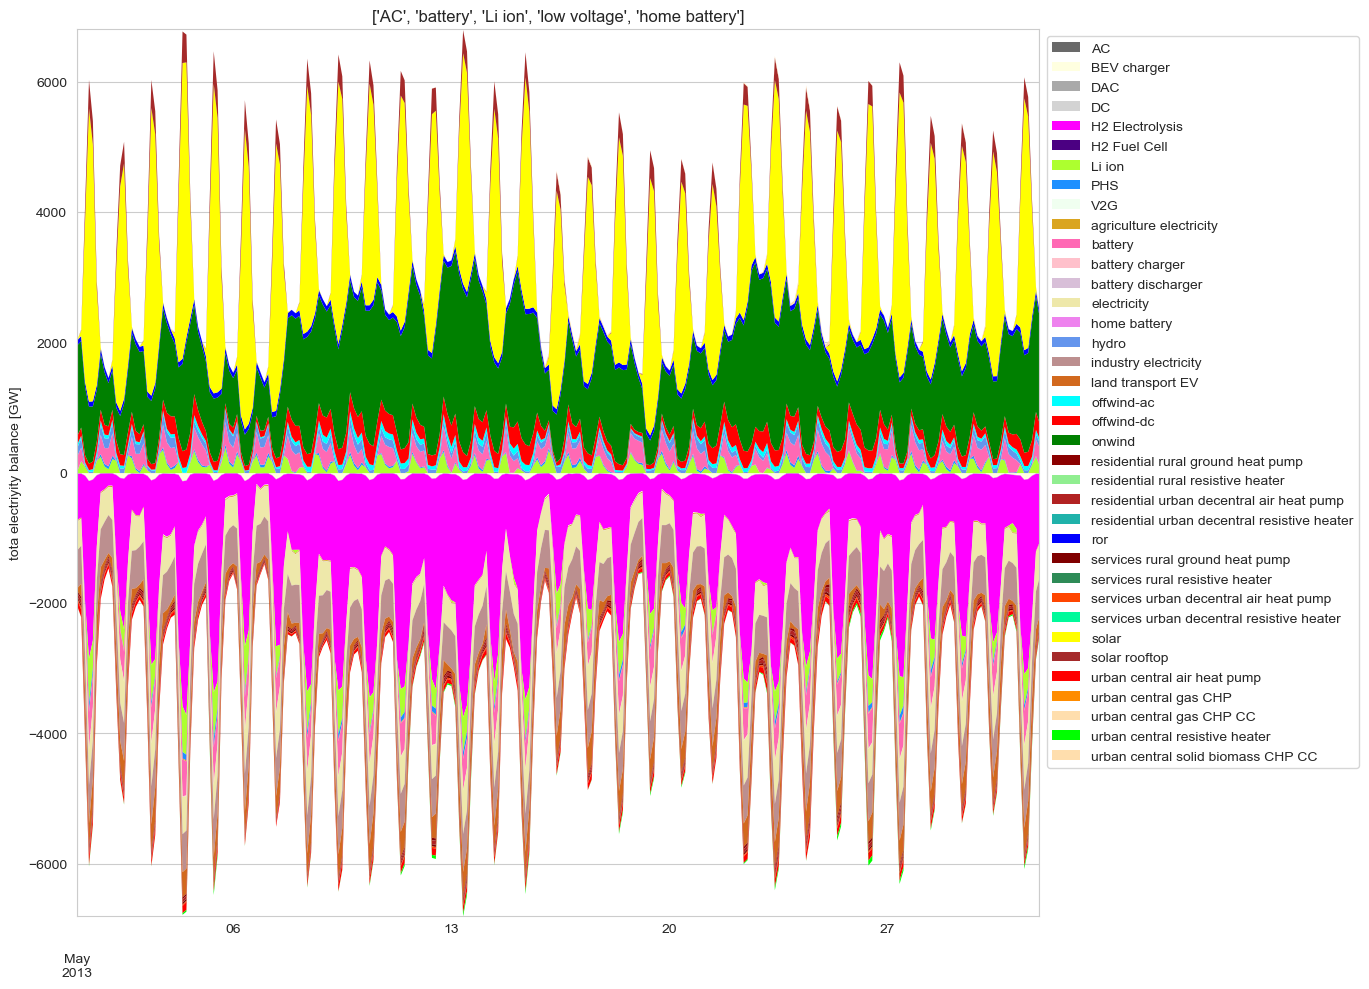

In [23]:
fig, ax = plt.subplots(figsize=(14, 10))

df = nb_el

# split into df with posititve and negative values and get colors
df_neg, df_pos = df.clip(upper=0), df.clip(lower=0)
c_neg, c_pos = [carrier_colors[col] for col in df_neg.columns], [carrier_colors[col] for col in df_pos.columns]

# plot positive values
df_pos.plot.area(ax=ax, stacked=True, color=c_pos, linewidth=0.)

# rename
df_neg.rename(columns=lambda x: '_' + x).plot.area(ax=ax, stacked=True, color=c_neg, linewidth=0.)

# rescale the y axis

ax.set_ylim([df_neg.sum(axis=1).min(), df_pos.sum(axis=1).max()])
ax.legend(ncol=1, loc="upper center", bbox_to_anchor=(1.17, 1))
ax.set_ylabel("tota electriyity balance [GW]")
ax.set_xlabel("")
ax.set_title(f"{carrier}")
fig.tight_layout()

### H2 plot

In [ ]:
carrier = ["H2"] # ["H2", "H2 liquid"]
nb_h2 = nodal_balance(n, carrier, time="2013-05", aggregate=['component', 'bus'], energy=True)   # in units of energy
# convert from MW to GW
nb_h2 = nb_h2.unstack(level=[1]) / 1000
nb_h2.head()

In [ ]:
# get carriers that are present
nb_h2.columns

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

df = nb_h2

# split into df with posititve and negative values and get colors
df_neg, df_pos = df.clip(upper=0), df.clip(lower=0)
c_neg, c_pos = [carrier_colors[col] for col in df_neg.columns], [carrier_colors[col] for col in df_pos.columns]

# plot positive values
df_pos.plot.area(ax=ax, stacked=True, color=c_pos, linewidth=0.)

# rename
df_neg.rename(columns=lambda x: '_' + x).plot.area(ax=ax, stacked=True, color=c_neg, linewidth=0.)

# rescale the y axis
ax.set_ylim([df_neg.sum(axis=1).min(), df_pos.sum(axis=1).max()])
ax.legend(ncol=1, loc="upper center", bbox_to_anchor=(1.1, 1))
ax.set_ylabel("total hydrogen balance [GW]")
ax.set_xlabel("")
ax.set_title(f"{carrier}")
fig.tight_layout()

### Heat plot

In [ ]:
nb_heat = nodal_balance(n, ["residential rural heat", "services rural heat", "residential urban decentral heat", "services urban decentral heat", "urban central heat"], time="2013-05", aggregate=['component', 'bus'], energy=True)   # in units of energy
# convert from MW to GW
nb_heat = nb_heat.unstack(level=[1]) / 1000
nb_heat.head()

In [ ]:
fig, ax = plt.subplots(figsize=(14, 10))

df = nb_heat

# split into df with posititve and negative values and get colors
df_neg, df_pos = df.clip(upper=0), df.clip(lower=0)
c_neg, c_pos = [carrier_colors[col] for col in df_neg.columns], [carrier_colors[col] for col in df_pos.columns]

# plot positive values
df_pos.plot.area(ax=ax, stacked=True, color=c_pos, linewidth=0.)

# rename
df_neg.rename(columns=lambda x: '_' + x).plot.area(ax=ax, stacked=True, color=c_neg, linewidth=0.)

# rescale the y axis

ax.set_ylim([df_neg.sum(axis=1).min(), df_pos.sum(axis=1).max()])
ax.legend(ncol=1, loc="upper center", bbox_to_anchor=(1.21, 1.005))
ax.set_ylabel("total hydrogen balance [GW]")
ax.set_xlabel("")
ax.set_title(f"{carrier}")
fig.tight_layout()

In [ ]:
carrier = ["urban central heat"]
nb_ucheat = nodal_balance(n, carrier=carrier, time="2013-05", aggregate=['component', 'bus'], energy=True)   # in units of energy
# convert from MW to GW
nb_ucheat = nb_ucheat.unstack(level=[1]) / 1000
nb_ucheat.head()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

df = nb_ucheat

# split into df with posititve and negative values and get colors
df_neg, df_pos = df.clip(upper=0), df.clip(lower=0)
c_neg, c_pos = [carrier_colors[col] for col in df_neg.columns], [carrier_colors[col] for col in df_pos.columns]

# plot positive values
df_pos.plot.area(ax=ax, stacked=True, color=c_pos, linewidth=0.)

# rename
df_neg.rename(columns=lambda x: '_' + x).plot.area(ax=ax, stacked=True, color=c_neg, linewidth=0.)

# rescale the y axis

ax.set_ylim([df_neg.sum(axis=1).min(), df_pos.sum(axis=1).max()])
ax.legend(ncol=1, loc="upper center", bbox_to_anchor=(1.18, 1))
ax.set_ylabel("total energy balance [GW]")
ax.set_xlabel("")
ax.set_title(f"{carrier}")
fig.tight_layout()

## LMP Determination

In [ ]:
# find snap with easy determination of marginal generator
n.generators_t.p

In [ ]:
n.global_constraints

In [ ]:
plt.plot(n.buses_t.marginal_price[["AL0 0"]][0:100])

In [ ]:
# find snap with easy determination of marginal generator
n.generators_t.p

In [ ]:
n.buses_t.marginal_price

In [ ]:
n.generators.loc["AL0 0 solar"]